In [82]:
# Regularización Ridge, Lasso y Elastic Net con Python por Joaquín Amat Rodrigo,
# disponible con licencia CC BY-NC-SA 4.0 en
# https://www.cienciadedatos.net/documentos/py14-ridge-lasso-elastic-net-python.html


# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNetCV

# Configuración matplotlib
# ==============================================================================
plt.rcParams['image.cmap'] = "bwr"
#plt.rcParams['figure.dpi'] = "100"
plt.rcParams['savefig.bbox'] = "tight"
style.use('ggplot') or plt.style.use('ggplot')

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')


In [83]:
# Datos
# ==============================================================================
datos = pd.read_csv('https://raw.githubusercontent.com/palasatenea66/DATASETS/main/meatspec.csv')
datos = datos.drop(columns = datos.columns[0])
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Columns: 101 entries, V1 to fat
dtypes: float64(101)
memory usage: 169.8 KB


In [84]:
datos

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V92,V93,V94,V95,V96,V97,V98,V99,V100,fat
0,2.61776,2.61814,2.61859,2.61912,2.61981,2.62071,2.62186,2.62334,2.62511,2.62722,...,2.98145,2.96072,2.94013,2.91978,2.89966,2.87964,2.85960,2.83940,2.81920,22.5
1,2.83454,2.83871,2.84283,2.84705,2.85138,2.85587,2.86060,2.86566,2.87093,2.87661,...,3.29186,3.27921,3.26655,3.25369,3.24045,3.22659,3.21181,3.19600,3.17942,40.1
2,2.58284,2.58458,2.58629,2.58808,2.58996,2.59192,2.59401,2.59627,2.59873,2.60131,...,2.68951,2.67009,2.65112,2.63262,2.61461,2.59718,2.58034,2.56404,2.54816,8.4
3,2.82286,2.82460,2.82630,2.82814,2.83001,2.83192,2.83392,2.83606,2.83842,2.84097,...,2.97367,2.94951,2.92576,2.90251,2.87988,2.85794,2.83672,2.81617,2.79622,5.9
4,2.78813,2.78989,2.79167,2.79350,2.79538,2.79746,2.79984,2.80254,2.80553,2.80890,...,3.30025,3.27907,3.25831,3.23784,3.21765,3.19766,3.17770,3.15770,3.13753,25.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,3.14626,3.15166,3.15703,3.16244,3.16791,3.17348,3.17923,3.18521,3.19140,3.19792,...,3.61483,3.59695,3.57915,3.56142,3.54365,3.52563,3.50705,3.48765,3.46769,31.3
211,2.57992,2.58040,2.58099,2.58175,2.58266,2.58381,2.58530,2.58719,2.58949,2.59225,...,2.95464,2.93756,2.92062,2.90367,2.88668,2.86951,2.85180,2.83347,2.81473,33.8
212,2.56875,2.56923,2.56985,2.57060,2.57150,2.57268,2.57420,2.57610,2.57841,2.58129,...,2.94870,2.93226,2.91592,2.89952,2.88291,2.86595,2.84836,2.82998,2.81111,35.5
213,2.65884,2.65943,2.66023,2.66108,2.66215,2.66360,2.66550,2.66787,2.67070,2.67405,...,3.04851,3.03351,3.01851,3.00327,2.98759,2.97121,2.95374,2.93514,2.91564,42.5


In [85]:
# 📌 1. Definimos función auxiliar
def tidy_corr_matrix(corr_mat):
    '''
    Convierte una matriz de correlación de pandas en formato "tidy" (ordenado).
    Cada fila representa un par de variables y su correlación.
    '''
    # Apila la matriz de correlación en formato largo
    corr_mat = corr_mat.stack().reset_index()
    # Renombramos columnas
    corr_mat.columns = ['variable_1','variable_2','r']
    # Quitamos pares de la diagonal (una variable consigo misma)
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    # Agregamos columna con valor absoluto de la correlación
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    # Ordenamos por |r| de mayor a menor
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)

    return corr_mat

# 📌 2. Calculamos la matriz de correlación
# - select_dtypes: nos quedamos solo con columnas numéricas (float64, int)
# - .corr(method='pearson'): calculamos la correlación de Pearson
corr_matrix = datos.select_dtypes(include=['float64', 'int']) \
                   .corr(method='pearson')

# 📌 3. Transformamos la matriz en formato tidy
tidy = tidy_corr_matrix(corr_matrix)

# 📌 4. Mostramos las 10 correlaciones más fuertes
display(tidy.head(10))


,variable_1,variable_2,r,abs_r
1019,V11,V10,0.999996,0.999996
919,V10,V11,0.999996,0.999996
1021,V11,V12,0.999996,0.999996
1121,V12,V11,0.999996,0.999996
917,V10,V9,0.999996,0.999996
817,V9,V10,0.999996,0.999996
1123,V12,V13,0.999996,0.999996
1223,V13,V12,0.999996,0.999996
715,V8,V9,0.999995,0.999995
815,V9,V8,0.999995,0.999995


In [86]:
tidy.tail(10)

,variable_1,variable_2,r,abs_r
10104,fat,V5,0.366019,0.366019
504,V5,fat,0.366019,0.366019
10108,fat,V9,0.365803,0.365803
908,V9,fat,0.365803,0.365803
10105,fat,V6,0.365604,0.365604
605,V6,fat,0.365604,0.365604
807,V8,fat,0.365483,0.365483
10107,fat,V8,0.365483,0.365483
706,V7,fat,0.365418,0.365418
10106,fat,V7,0.365418,0.365418


In [87]:
tidy.shape

(10100, 4)

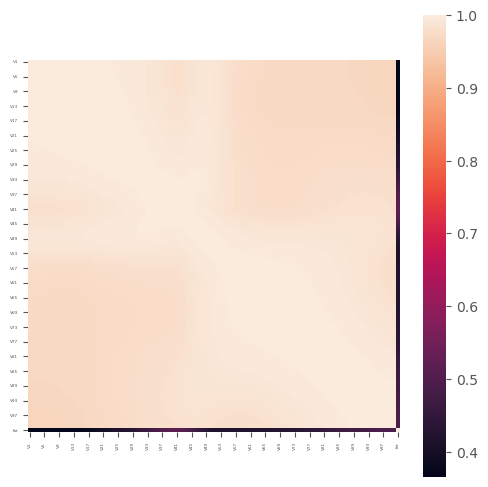

In [88]:
# Heatmap matriz de correlaciones
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))

sns.heatmap(
    corr_matrix,
    square    = True,
    ax        = ax
)

ax.tick_params(labelsize = 3)

In [89]:
# División de los datos en train y test
# ==============================================================================
X = datos.drop(columns='fat')
y = datos['fat']

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.7,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

In [90]:
# Estandarizar datos

st=StandardScaler().fit(X_train)
X_std=st.transform(X_train)
X_test_std=st.transform(X_test)


In [91]:
# Creación y entrenamiento del modelo
# ==============================================================================
modelo = LinearRegression()
modelo.fit(X = X_std, y = y_train)

LinearRegression()

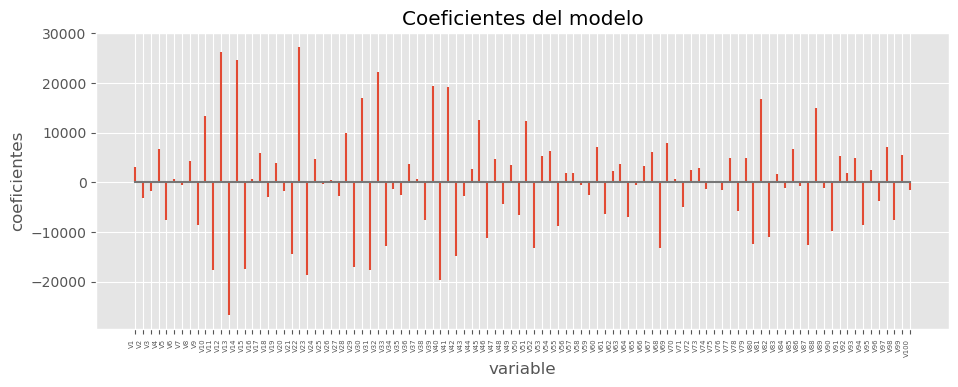

In [92]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [93]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test_std)
predicciones = predicciones.flatten()
predicciones[:10]

array([36.88226752, 62.47992661, 61.04825535,  9.95161352, 18.11993067,
        6.56158193, 28.42860453,  9.18085599, 15.56800749, 16.50461443])

In [94]:
# Error de test del modelo
# ==============================================================================
rmse_ols = mean_squared_error(
            y_true  = y_test,
            y_pred  = predicciones,
           )
rmse_ols = np.sqrt(rmse_ols)
print("")
print(f"El error (rmse) de test es: {rmse_ols}")


El error (rmse) de test es: 3.8396675856181246


In [95]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto RidgeCV utiliza el mean squared error
'''class sklearn.linear_model.RidgeCV(alphas=(0.1, 1.0, 10.0), *, fit_intercept=True,
scoring=None, cv=None, gcv_mode=None, store_cv_results=None, alpha_per_target=False,
store_cv_values='deprecated')'''

modelo = RidgeCV(
            alphas          = np.logspace(-10, 2, 200),
            fit_intercept   = True,
            store_cv_values = True,
         )

_ = modelo.fit(X = X_std, y = y_train)

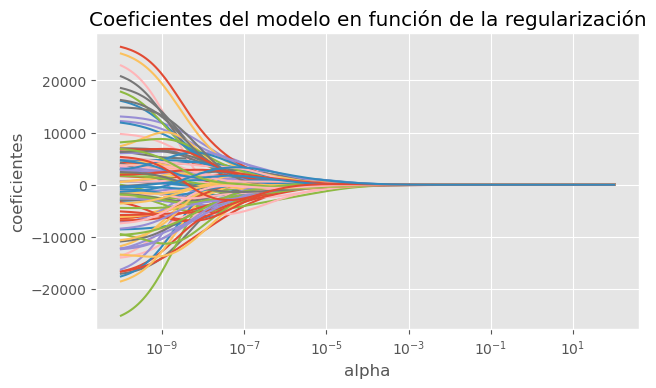

In [96]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo.alphas
coefs = []

for alpha in alphas:
    modelo_temp = Ridge(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_std, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización');
plt.axis('tight')
plt.show()

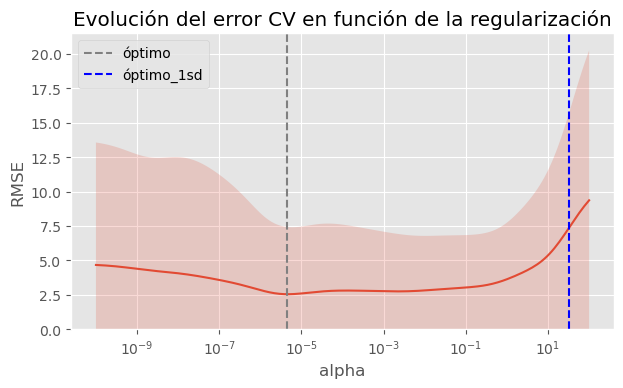

In [97]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.cv_values almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_samples, n_targets, n_alphas)
mse_cv = modelo.cv_values_.reshape((-1, 200)).mean(axis=0)
mse_sd = modelo.cv_values_.reshape((-1, 200)).std(axis=0)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas[rmse_cv == min_rsme_1sd]


# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas, rmse_cv)
ax.fill_between(
    modelo.alphas,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)
ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend();

In [98]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 4.397603609302721e-06


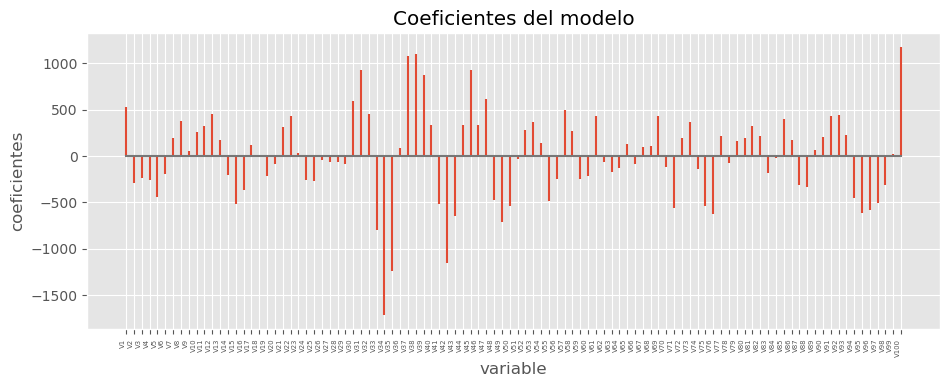

In [99]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [100]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test_std)
predicciones = predicciones.flatten()
predicciones[:10]

array([43.14208123, 40.36062055, 51.87965692, 10.00021307, 17.88565923,
        7.64607367, 28.18338642,  8.21648677, 14.70668161, 14.3772609 ])

In [101]:
# Error de test del modelo
# ==============================================================================
rmse_ridge = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones
             )
print("")
print(f"El error (rmse) de test es: {rmse_ridge}")


El error (rmse) de test es: 6.023401335878741


In [102]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto LassoCV utiliza el mean squared error
'''
class sklearn.linear_model.LassoCV(*, eps=0.001, n_alphas=100, alphas=None, fit_intercept=True,
precompute='auto', max_iter=1000, tol=0.0001, copy_X=True, cv=None, verbose=False, n_jobs=None,
positive=False, random_state=None, selection='cyclic')
'''

modelo = LassoCV(alphas = np.logspace(-10, 3, 200), cv = 10)
_ = modelo.fit(X = X_std, y = y_train)

Text(0.5, 1.0, 'Coeficientes del modelo en función de la regularización')

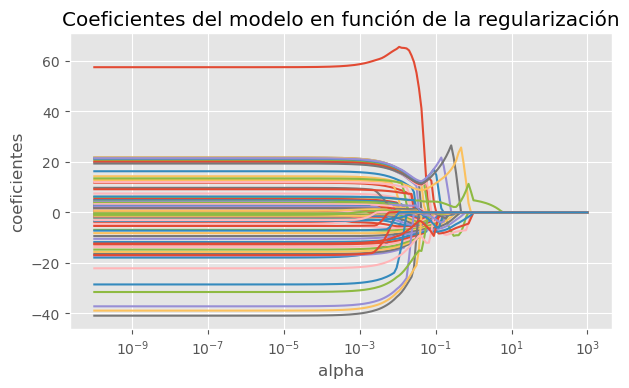

In [103]:
# Evolución de los coeficientes en función de alpha
# ==============================================================================
alphas = modelo.alphas_
coefs = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_std, y_train)
    coefs.append(modelo_temp.coef_.flatten())

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, coefs)
ax.set_xscale('log')

ax.set_xlabel('alpha')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo en función de la regularización')

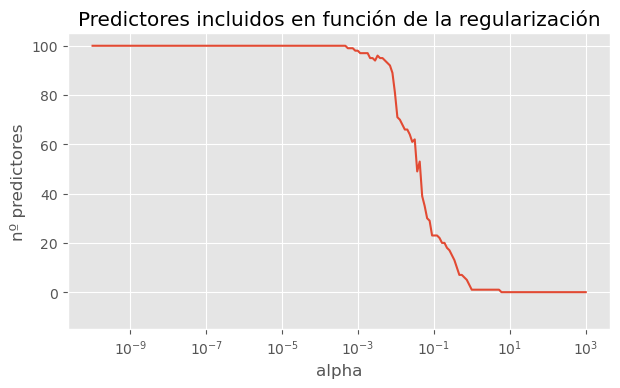

In [104]:
# Número de predictores incluidos (coeficiente !=0) en función de alpha
# ==============================================================================
alphas = modelo.alphas_
n_predictores = []

for alpha in alphas:
    modelo_temp = Lasso(alpha=alpha, fit_intercept=False)
    modelo_temp.fit(X_std, y_train)
    coef_no_cero = np.sum(modelo_temp.coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-15,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº predictores')
ax.set_title('Predictores incluidos en función de la regularización');

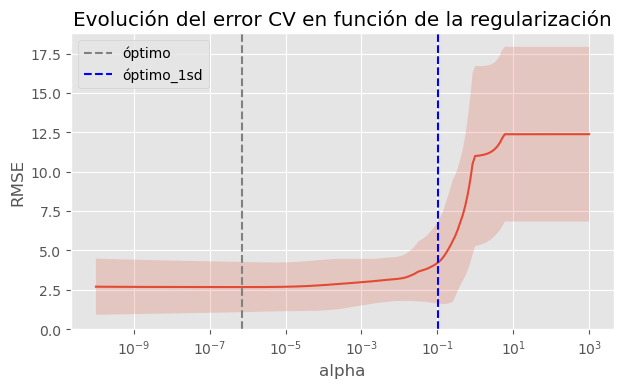

In [105]:
# Evolución del error en función de alpha
# ==============================================================================
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha. Tiene
# dimensiones (n_alphas, n_folds)
mse_cv = modelo.mse_path_.mean(axis=1)
mse_sd = modelo.mse_path_.std(axis=1)

# Se aplica la raíz cuadrada para pasar de mse a rmse
rmse_cv = np.sqrt(mse_cv)
rmse_sd = np.sqrt(mse_sd)

# Se identifica el óptimo y el óptimo + 1std
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

# Gráfico del error +- 1 desviación estándar
fig, ax = plt.subplots(figsize=(7, 3.84))
ax.plot(modelo.alphas_, rmse_cv)
ax.fill_between(
    modelo.alphas_,
    rmse_cv + rmse_sd,
    rmse_cv - rmse_sd,
    alpha=0.2
)

ax.axvline(
    x         = optimo,
    c         = "gray",
    linestyle = '--',
    label     = 'óptimo'
)

ax.axvline(
    x         = optimo_1sd,
    c         = "blue",
    linestyle = '--',
    label     = 'óptimo_1sd'
)

ax.set_xscale('log')
ax.set_ylim([0,None])
ax.set_title('Evolución del error CV en función de la regularización')
ax.set_xlabel('alpha')
ax.set_ylabel('RMSE')
plt.legend()

In [106]:
# Mejor valor alpha encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")

Mejor valor de alpha encontrado: 7.149428986597591e-07


In [107]:
# Mejor valor alpha encontrado + 1sd
# ==============================================================================
min_rmse     = np.min(rmse_cv)
sd_min_rmse  = rmse_sd[np.argmin(rmse_cv)]
min_rsme_1sd = np.max(rmse_cv[rmse_cv <= min_rmse + sd_min_rmse])
optimo       = modelo.alphas_[np.argmin(rmse_cv)]
optimo_1sd   = modelo.alphas_[rmse_cv == min_rsme_1sd]

print(f"Mejor valor de alpha encontrado + 1 desviación estándar: {optimo_1sd}")

Mejor valor de alpha encontrado + 1 desviación estándar: [0.10353218]


In [108]:
# Mejor modelo alpha óptimo + 1sd
# ==============================================================================
modelo = Lasso(alpha=float(optimo_1sd[0]))
modelo.fit(X_std, y_train)

Lasso(alpha=0.10353218432956658)

In [109]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

# Predictores incluidos en el modelo (coeficiente != 0)
df_coeficientes[df_coeficientes.coef != 0]

,predictor,coef
7,V8,-7.230652
8,V9,-7.615356
9,V10,-6.644370
10,V11,-5.841531
11,V12,-5.027635
12,V13,-4.201628
13,V14,-3.320370
14,V15,-2.475391
15,V16,-1.705261
16,V17,-1.022169


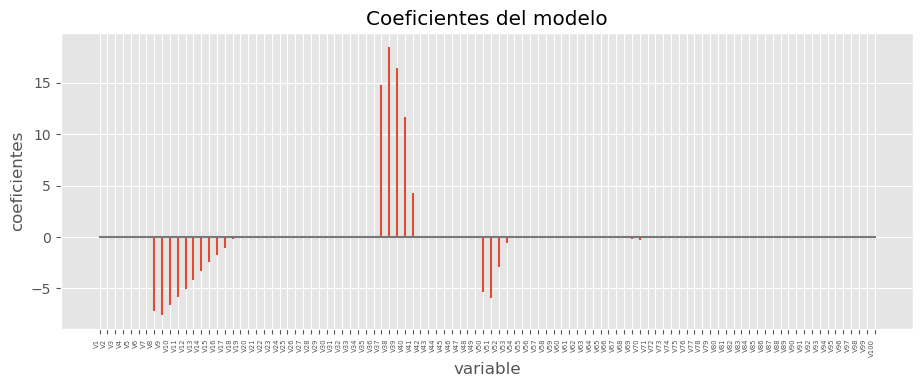

In [110]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [111]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test_std)
predicciones = predicciones.flatten()
predicciones[:10]

array([34.02536159, 53.11087452, 35.75425264, 11.99819527, 15.14548287,
        6.42713465, 24.40691555,  7.50121086, 13.62452751, 18.97739918])

In [112]:
# Error de test del modelo
# ==============================================================================
rmse_lasso = mean_squared_error(y_true  = y_test, y_pred  = predicciones)
print("")
print(f"El error (rmse) de test es: {rmse_lasso}")


El error (rmse) de test es: 15.00179438767624


In [113]:
# Creación y entrenamiento del modelo (con búsqueda por CV del valor óptimo alpha)
# ==============================================================================
# Por defecto ElasticNetCV utiliza el mean squared error
'''
class sklearn.linear_model.ElasticNet(alpha=1.0, *, l1_ratio=0.5, fit_intercept=True,
precompute=False, max_iter=1000, copy_X=True, tol=0.0001, warm_start=False,
positive=False, random_state=None, selection='cyclic')

class sklearn.linear_model.ElasticNetCV(*, l1_ratio=0.5, eps=0.001, n_alphas=100,
alphas=None, fit_intercept=True, precompute='auto', max_iter=1000, tol=0.0001, cv=None,
 copy_X=True, verbose=0, n_jobs=None, positive=False, random_state=None, selection='cyclic')

'''
modelo = ElasticNetCV(l1_ratio        = [0, 0.1, 0.5, 0.7, 0.9, 0.95, 0.99],
            alphas          = np.logspace(-10, 3, 200),
            cv              = 10)
_ = modelo.fit(X = X_std, y = y_train)

In [114]:
# Evolución del error en función de alpha y l1_ratio
# ==============================================================================
# modelo.mse_path_ almacena el mse de cv para cada valor de alpha y l1_ratio.
# Tiene dimensiones (n_l1_ratio, n_alpha, n_folds)

# Error medio de las 10 particiones por cada valor de alpha y l1_ratio
mean_error_cv = modelo.mse_path_.mean(axis =2)

# El resultado es un array de dimensiones (n_l1_ratio, n_alpha)
# Se convierte en un dataframe
df_resultados_cv = pd.DataFrame(
                        data   = mean_error_cv.flatten(),
                        index  = pd.MultiIndex.from_product(
                                    iterables = [modelo.l1_ratio, modelo.alphas_],
                                    names     = ['l1_ratio', 'modelo.alphas_']
                                 ),
                        columns = ["mse_cv"]
                    )

df_resultados_cv['rmse_cv'] = np.sqrt(df_resultados_cv['mse_cv'])
df_resultados_cv = df_resultados_cv.reset_index().sort_values('mse_cv', ascending = True)
df_resultados_cv

,l1_ratio,modelo.alphas_,mse_cv,rmse_cv
1338,0.99,9.658832e-07,7.120928,2.668507
1339,0.99,8.309942e-07,7.121027,2.668525
1337,0.99,1.122668e-06,7.121126,2.668544
1340,0.99,7.149429e-07,7.121365,2.668589
1336,0.99,1.304902e-06,7.121685,2.668649
...,...,...,...,...
824,0.90,2.704960e+01,153.287425,12.380930
823,0.90,3.144035e+01,153.287425,12.380930
822,0.90,3.654383e+01,153.287425,12.380930
831,0.90,9.437878e+00,153.287425,12.380930


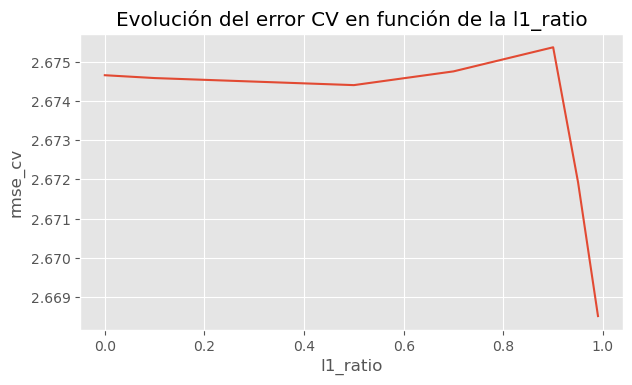

In [115]:
# Mejor valor encontrado para cada l1_ratio
fig, ax = plt.subplots(figsize=(7, 3.84))
df_resultados_cv.groupby('l1_ratio')['rmse_cv'].min().plot(ax = ax)
ax.set_title('Evolución del error CV en función de la l1_ratio')
ax.set_xlabel('l1_ratio')
ax.set_ylabel('rmse_cv');

In [116]:
# Mejor valor alpha y l1_ratio_ encontrado
# ==============================================================================
print(f"Mejor valor de alpha encontrado: {modelo.alpha_}")
print(f"Mejor valor de l1_ratio encontrado: {modelo.l1_ratio_}")

Mejor valor de alpha encontrado: 9.658832241158708e-07
Mejor valor de l1_ratio encontrado: 0.99


In [117]:
# Coeficientes del modelo
# ==============================================================================
df_coeficientes = pd.DataFrame(
                        {'predictor': X_train.columns,
                         'coef': modelo.coef_.flatten()}
                  )

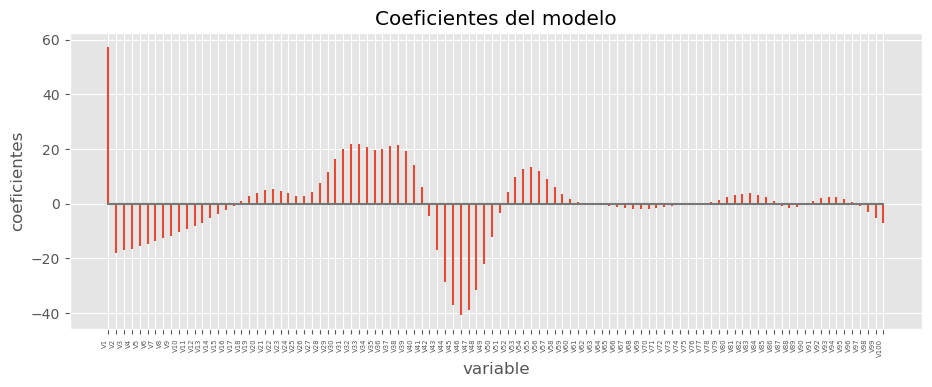

In [118]:
fig, ax = plt.subplots(figsize=(11, 3.84))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=5)
ax.set_xlabel('variable')
ax.set_ylabel('coeficientes')
ax.set_title('Coeficientes del modelo');

In [119]:
# Predicciones test
# ==============================================================================
predicciones = modelo.predict(X=X_test_std)
predicciones = predicciones.flatten()

In [120]:
# Error de test del modelo
# ==============================================================================
rmse_elastic = mean_squared_error(
                y_true  = y_test,
                y_pred  = predicciones)
print("")
print(f"El error (rmse) de test es: {rmse_elastic}")


El error (rmse) de test es: 27.38301715012016


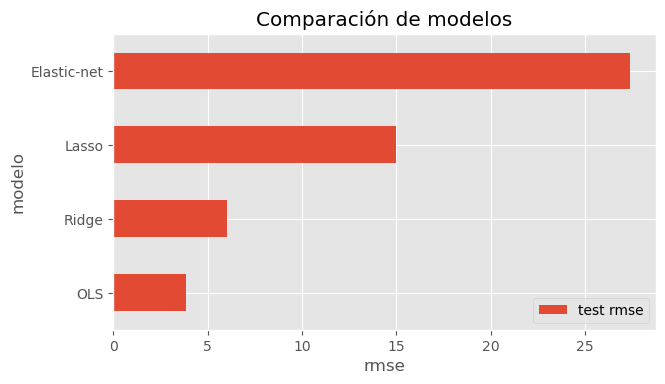

In [121]:
df_comparacion = pd.DataFrame({
                    'modelo': ['OLS', 'Ridge', 'Lasso', 'Elastic-net'],
                    'test rmse': [rmse_ols, rmse_ridge, rmse_lasso, rmse_elastic]
                 })

fig, ax = plt.subplots(figsize=(7, 3.84))
df_comparacion.set_index('modelo').plot(kind='barh', ax=ax)
ax.set_xlabel('rmse')
ax.set_ylabel('modelo')
ax.set_title('Comparación de modelos');